Linear SVM in TensorFlow

In this task I implemented a linear SVM classifier for binary classification using TensorFlow and train it for the breast cancer dataset below.

One of the ways to fit a linear SVM is to pose the following unconstrained optimization problem:

\begin{equation*}
L(w, x_i, y_i) = \lVert w \lVert^2 + C \sum^{N}_{i} \text{max}(0,1-y_i f(x_i)),
\end{equation*}

where $f(x_i) = w^T x_i + b$.



In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf

n_batch = 4;
n_classes = 2;
n_feat = 30

# set random seed to reproduce the results if necessary
seed = 5
np.random.seed(seed)
tf.set_random_seed(seed)

tf.reset_default_graph()

# two placeholders for the input and the target
X_node = tf.placeholder(tf.float32, shape=[n_batch, n_feat])
target_node = tf.placeholder(tf.float32, shape=[n_batch, 1])
C = tf.placeholder(tf.float32)

# declare the variable for weights and biases
w = tf.Variable(tf.random_normal([n_feat, 1]), name="w")
b = tf.Variable(tf.zeros([1]), name="b")


f = tf.matmul(X_node, w) + b
l = tf.nn.relu(1 - target_node*f)


acc = tf.count_nonzero(tf.greater(target_node*f, 0.))
loss = tf.reduce_mean(w*w) + C*tf.reduce_sum(l)



train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  
from sklearn.preprocessing import StandardScaler

breast_cancer_data = load_breast_cancer()

# each traning sample has 30 features

print(breast_cancer_data.data.shape)

# these are the target labels
print(breast_cancer_data.target.shape)

# 0 - malignant tumour
# 1 - benign tumour
print(breast_cancer_data.target_names)
y_data = breast_cancer_data.target
X_data = breast_cancer_data.data
y_data[y_data == 0] = -1
X_data = X_data.astype(np.float32)
y_data = y_data.astype(np.float32)
print(y_data[0])

(569, 30)
(569,)
['malignant' 'benign']
-1.0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_data)
X_data = scaler.transform(X_data)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
print(y_test.shape)

(171,)


In [4]:
def generate_minibatches(X, n_batch):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_indx in range(0, len(X) - n_batch + 1, n_batch):
        batch_indices = indices[start_indx:start_indx+n_batch]
        yield batch_indices

In [5]:
def minibatch_sgd(X, y, c):
    n_train = X.shape[0]
    rng_minibatches = n_train/4
    y = y.reshape((n_train,1))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())    
        loss_train_epoch = {}
        for i_epoch in range(0,50):
            loss_train = 0
            acc_train = 0
            for bacth_indices in generate_minibatches(X, 4):
                X_train_minibatch = X[bacth_indices]
                y_train_minibatch = y[bacth_indices]
                [loss_val,acc_val, l_val, f_val, w_val] = sess.run([loss,acc,l, f, w], feed_dict={X_node:X_train_minibatch, target_node:y_train_minibatch, C:c})
                if acc_val < 4:
                    train_step.run(feed_dict={X_node: X_train_minibatch, target_node: y_train_minibatch, C:c})
                loss_train += loss_val
                acc_train += acc_val    
            loss_train_epoch[i_epoch] = loss_train/rng_minibatches
        omega = sess.run([w])
        beta = sess.run([b])
    return omega, beta, loss_train_epoch


In [6]:
def accuracy(X, y, omega, beta):
    acc = 0
    for x, y in zip(X_test, y_test):
        if y*(x.dot(omega) + beta) >= 0:
            acc += 1
    return acc/X_test.shape[0]*100

In [10]:
c_list = []
acc_list = []
for c in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    omega, beta, _ = minibatch_sgd(X_train, y_train, c)
    c_list.append(c)
    acc_list.append(accuracy(X_test, y_test, omega, beta))
    for x, y in zip(X_data, y_data):
        if  -1 <=y*(x.dot(omega) + beta) <= 1:
            print(x)

[ 1.0970647  -2.0733352   1.2699338   0.98437524  1.5684686   3.2835152
  2.652875    2.5324743   2.2175107   2.2557442   2.489735   -0.56526625
  2.833031    2.4875777  -0.21400194  1.3168615   0.72402555  0.6608185
  1.1487573   0.9070836   1.8866893  -1.3592957   2.3036005   2.0012379
  1.3076851   2.6166644   2.1095269   2.296076    2.75062     1.9370172 ]
[ 1.8298215e+00 -3.5363334e-01  1.6859545e+00  1.9087087e+00
 -8.2696050e-01 -4.8707229e-01 -2.3845309e-02  5.4814368e-01
  1.3883719e-03 -8.6865538e-01  4.9925452e-01 -8.7624478e-01
  2.6332682e-01  7.4240232e-01 -6.0535115e-01 -6.9292629e-01
 -4.4078064e-01  2.6016071e-01 -8.0544996e-01 -9.9443547e-02
  1.8059273e+00 -3.6920524e-01  1.5351257e+00  1.8904895e+00
 -3.7561318e-01 -4.3044409e-01 -1.4674868e-01  1.0870839e+00
 -2.4389093e-01  2.8119272e-01]
[ 1.5798892   0.4561855   1.5665032   1.558884    0.94221264  1.0529253
  1.3634791   2.03723     0.9396808  -0.3980106   1.2286761  -0.7800846
  0.8509282   1.1813363  -0.297005

[ 0.28478402  2.4481537   0.19528136  0.18376023 -0.93655515 -1.1047012
 -0.5265465  -0.55532265  0.14742638 -1.3974216   0.22712     0.74414563
  0.08759094  0.11095326 -0.06999608 -0.6264177  -0.23222296 -0.43944943
  1.3279536  -0.77348757  0.20517915  1.8291867   0.0845551   0.08933169
 -0.77013636 -0.9898653  -0.5636535  -0.7439149   0.53749686 -1.2355379 ]
[-0.6354221   0.43756896 -0.6417035  -0.62880003  0.09747901 -0.4385564
 -0.7940929  -0.6997689   0.75713384  0.01451215 -0.4709016  -0.02513619
 -0.4633782  -0.4577909   0.9513786   0.28234613 -0.5170418  -0.4087918
  0.24672243 -0.5760403  -0.66663843  0.24960124 -0.6603889  -0.62877584
  0.44850147 -0.22624326 -0.7473987  -0.4868899   0.2818876  -0.5783065 ]
[-1.3411976   0.5609036  -1.3332869  -1.0912511   0.5721524  -0.8101951
 -0.8578722  -0.93758935  0.7790393   0.45538694  0.09033088  3.01389
 -0.05299772 -0.33370128  2.5664442  -0.48837057 -0.6042447  -0.50644195
  1.1983998   0.30074653 -1.12222     0.90586203 -1.1476

[ 1.0970647  -2.0733352   1.2699338   0.98437524  1.5684686   3.2835152
  2.652875    2.5324743   2.2175107   2.2557442   2.489735   -0.56526625
  2.833031    2.4875777  -0.21400194  1.3168615   0.72402555  0.6608185
  1.1487573   0.9070836   1.8866893  -1.3592957   2.3036005   2.0012379
  1.3076851   2.6166644   2.1095269   2.296076    2.75062     1.9370172 ]
[ 1.8298215e+00 -3.5363334e-01  1.6859545e+00  1.9087087e+00
 -8.2696050e-01 -4.8707229e-01 -2.3845309e-02  5.4814368e-01
  1.3883719e-03 -8.6865538e-01  4.9925452e-01 -8.7624478e-01
  2.6332682e-01  7.4240232e-01 -6.0535115e-01 -6.9292629e-01
 -4.4078064e-01  2.6016071e-01 -8.0544996e-01 -9.9443547e-02
  1.8059273e+00 -3.6920524e-01  1.5351257e+00  1.8904895e+00
 -3.7561318e-01 -4.3044409e-01 -1.4674868e-01  1.0870839e+00
 -2.4389093e-01  2.8119272e-01]
[ 1.5798892   0.4561855   1.5665032   1.558884    0.94221264  1.0529253
  1.3634791   2.03723     0.9396808  -0.3980106   1.2286761  -0.7800846
  0.8509282   1.1813363  -0.297005

[-0.49341497 -0.42111847 -0.46664512 -0.5460366   0.5579191   0.48059067
 -0.37513348 -0.51895314 -0.11909261  0.4369584  -0.5210696  -0.62386954
 -0.37080738 -0.46505147 -0.1086643   0.646746    0.5197784  -0.20862503
 -0.26180744  1.1684552  -0.4326351  -0.4148016  -0.35836023 -0.4923618
  0.45288512  0.66816884  0.23225571 -0.252248   -0.13226438  1.5435649 ]
[-0.24064244 -1.296095   -0.25451553 -0.32163692 -0.90595376 -0.35232723
 -0.4774565  -0.52308017 -0.7105456  -0.97214055 -0.80078346 -1.2447381
 -0.6306985  -0.5517382  -0.92336404 -0.26537132 -0.11982068 -0.53985715
 -0.7182734  -0.44705656 -0.42021027 -1.3527819  -0.3178517  -0.4515782
 -0.6912317   0.09055422  0.06913985 -0.34832785 -0.26653975 -0.5954852 ]
[ 0.13425656  0.93090713  0.0824203   0.02790342 -0.6789363  -0.7197966
 -0.06151031  0.09778085 -0.6740361  -1.2244741   0.03799723  0.74414563
  0.02373201 -0.16120794  0.4236906  -0.4503657   0.06619029  0.6429757
 -0.3804643  -0.34946772 -0.09923226  0.9823985  -0.15

[ 1.8298215e+00 -3.5363334e-01  1.6859545e+00  1.9087087e+00
 -8.2696050e-01 -4.8707229e-01 -2.3845309e-02  5.4814368e-01
  1.3883719e-03 -8.6865538e-01  4.9925452e-01 -8.7624478e-01
  2.6332682e-01  7.4240232e-01 -6.0535115e-01 -6.9292629e-01
 -4.4078064e-01  2.6016071e-01 -8.0544996e-01 -9.9443547e-02
  1.8059273e+00 -3.6920524e-01  1.5351257e+00  1.8904895e+00
 -3.7561318e-01 -4.3044409e-01 -1.4674868e-01  1.0870839e+00
 -2.4389093e-01  2.8119272e-01]
[-0.76890886  0.25373057 -0.592687   -0.7644637   3.2835557   3.4029098
  1.9158981   1.4517066   2.8673787   4.910917    0.32637322 -0.11041022
  0.28659323 -0.2883778   0.6897014   2.74428     0.8195178   1.1150056
  4.7326818   2.0475118  -0.28146493  0.13398227 -0.24993978 -0.55002135
  3.3942735   3.8933964   1.9895889   2.175786    6.046038    4.935012  ]
[ 1.7502978  -1.151817    1.7765734   1.8262297   0.2803739   0.53934014
  1.3710121   1.4284921  -0.00956464 -0.5624526   1.270543   -0.7902449
  1.2731894   1.1903571   1.4830

[-0.47637424 -0.83533615 -0.38714802 -0.50565034  2.237424    1.2443355
  0.86630225  0.82465506  1.0053978   1.8900031  -0.25507066 -0.5926628
 -0.32130435 -0.28925782  0.15634638  0.4455436   0.16002461 -0.06912472
  0.13411938  0.48684627 -0.16549861 -0.3138383  -0.11500996 -0.24432032
  2.0485117   1.7216163   1.2632436   0.9058873   1.7540673   2.241804  ]
[-0.11851623  0.35844868 -0.07286692 -0.21896468  1.6040514   1.1401023
  0.06102623  0.28194982  1.4033508   1.6603509   0.64362305  0.29055968
  0.49005082  0.23372275  0.5880307   0.26893267 -0.23255455  0.43534726
 -0.6880037   0.6116693   0.1637625   0.40104607  0.09944802  0.02885943
  1.4479597   0.7247854  -0.02105356  0.62419516  0.4776387   1.7264369 ]
[ 0.5375568   0.9192715   0.44201055  0.40645346 -1.0176836  -0.7135426
 -0.7006839  -0.40468583 -1.0354795  -0.82612705 -0.09265617 -0.05416553
 -0.19804169  0.00380488 -1.0040339  -0.90592134 -0.6924425  -0.6821151
 -0.71948415 -0.28478667  0.60484856  1.33577     0.49

[-0.47637424 -0.83533615 -0.38714802 -0.50565034  2.237424    1.2443355
  0.86630225  0.82465506  1.0053978   1.8900031  -0.25507066 -0.5926628
 -0.32130435 -0.28925782  0.15634638  0.4455436   0.16002461 -0.06912472
  0.13411938  0.48684627 -0.16549861 -0.3138383  -0.11500996 -0.24432032
  2.0485117   1.7216163   1.2632436   0.9058873   1.7540673   2.241804  ]
[ 0.5375568   0.9192715   0.44201055  0.40645346 -1.0176836  -0.7135426
 -0.7006839  -0.40468583 -1.0354795  -0.82612705 -0.09265617 -0.05416553
 -0.19804169  0.00380488 -1.0040339  -0.90592134 -0.6924425  -0.6821151
 -0.71948415 -0.28478667  0.60484856  1.33577     0.49262127  0.47361144
 -0.62547773 -0.630828   -0.60587174 -0.22621053  0.07642965  0.03182149]
[ 0.48927435  1.0844934   0.48320076  0.36350757 -0.8789113  -0.0784783
  0.13284072  0.12176925  0.12917136 -1.3350469  -0.00675699 -0.25192916
  0.01828672 -0.08266176  0.909377    0.32314542  0.61726     1.3177679
  1.1221203  -0.29991674  0.11820447  0.3228811   0.141

[-0.47637424 -0.83533615 -0.38714802 -0.50565034  2.237424    1.2443355
  0.86630225  0.82465506  1.0053978   1.8900031  -0.25507066 -0.5926628
 -0.32130435 -0.28925782  0.15634638  0.4455436   0.16002461 -0.06912472
  0.13411938  0.48684627 -0.16549861 -0.3138383  -0.11500996 -0.24432032
  2.0485117   1.7216163   1.2632436   0.9058873   1.7540673   2.241804  ]
[ 0.15697767  0.19555391  0.11413662  0.08421662  0.16437417 -0.6129102
 -0.18643224  0.0946856  -0.82372457 -0.50716597  0.24372233  0.04199465
  0.16283557  0.1113933  -0.44101125 -0.774525   -0.39502394 -0.11454347
 -0.7800234  -0.64677334  0.5799985   0.8472382   0.48070687  0.4525165
  0.61507803 -0.42726344  0.09216792  0.70489615  0.2074694  -0.09895948]
[ 0.9777787  -0.98659533  0.9486501   0.8538308   0.15014137  0.21526976
  0.1249311   0.7895753  -0.26513064 -0.18537006  0.7042578  -0.715494
  0.8855804   0.45682007 -0.4713458   0.27116826  0.07215851  0.2828701
 -0.15646905 -0.02001067  0.7746562  -1.0026677   0.8232

[-0.76890886  0.25373057 -0.592687   -0.7644637   3.2835557   3.4029098
  1.9158981   1.4517066   2.8673787   4.910917    0.32637322 -0.11041022
  0.28659323 -0.2883778   0.6897014   2.74428     0.8195178   1.1150056
  4.7326818   2.0475118  -0.28146493  0.13398227 -0.24993978 -0.55002135
  3.3942735   3.8933964   1.9895889   2.175786    6.046038    4.935012  ]
[-0.47637424 -0.83533615 -0.38714802 -0.50565034  2.237424    1.2443355
  0.86630225  0.82465506  1.0053978   1.8900031  -0.25507066 -0.5926628
 -0.32130435 -0.28925782  0.15634638  0.4455436   0.16002461 -0.06912472
  0.13411938  0.48684627 -0.16549861 -0.3138383  -0.11500996 -0.24432032
  2.0485117   1.7216163   1.2632436   0.9058873   1.7540673   2.241804  ]
[-0.32016635  0.58882815 -0.18408033 -0.38420716  2.2018406   1.68401
  1.2190969   1.1506909   1.9655957   1.5724595  -0.35685042 -0.38981926
 -0.22774363 -0.35240275 -0.43667763  0.5332902   0.12056778  0.07524183
  0.10748224 -0.01736297 -0.16135707  0.82281166 -0.0316

[-0.47637424 -0.83533615 -0.38714802 -0.50565034  2.237424    1.2443355
  0.86630225  0.82465506  1.0053978   1.8900031  -0.25507066 -0.5926628
 -0.32130435 -0.28925782  0.15634638  0.4455436   0.16002461 -0.06912472
  0.13411938  0.48684627 -0.16549861 -0.3138383  -0.11500996 -0.24432032
  2.0485117   1.7216163   1.2632436   0.9058873   1.7540673   2.241804  ]
[-0.47353405  1.105437   -0.3294817  -0.5090633   1.5827019   2.563359
  1.7388728   0.9417598   0.79729384  2.783093   -0.38825062  0.69334406
 -0.4094198  -0.3607634   0.03600825  2.6095862   1.509847    0.4093937
 -0.32113573  2.3773472  -0.24419     2.443108   -0.28627855 -0.2974092
  2.3202937   5.112876    3.9954336   1.620015    2.3704417   6.8468575 ]
[ 0.48927435  1.0844934   0.48320076  0.36350757 -0.8789113  -0.0784783
  0.13284072  0.12176925  0.12917136 -1.3350469  -0.00675699 -0.25192916
  0.01828672 -0.08266176  0.909377    0.32314542  0.61726     1.3177679
  1.1221203  -0.29991674  0.11820447  0.3228811   0.14114

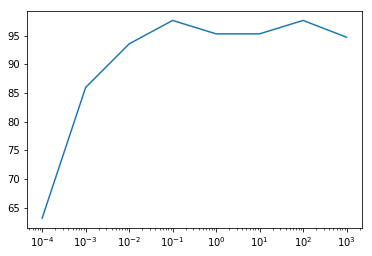

In [11]:
import matplotlib.pyplot as plt
plt.semilogx(c_list, acc_list)
         
